<a href="https://colab.research.google.com/github/MahlerTom/Siamese-Neural-Networks/blob/master/IntroToDeepEx02_Tom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Clone the entire repo.
!git clone -s git://github.com/MahlerTom/Siamese-Neural-Networks.git Siamese-Neural-Networks
repo_path = os.path.join(os.getcwd(), 'Siamese-Neural-Networks')
train_path = os.path.join(repo_path, 'data', 'train')
test_path = os.path.join(repo_path, 'data', 'test')

Cloning into 'Siamese-Neural-Networks'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 19072 (delta 7), reused 15 (delta 2), pack-reused 19048
Receiving objects: 100% (19072/19072), 192.48 MiB | 33.51 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

     |████████████████████████████████| 79.9MB 342kB/s 
     |████████████████████████████████| 3.0MB 39.0MB/s 
     |████████████████████████████████| 419kB 46.6MB/s 
     |████████████████████████████████| 61kB 22.9MB/s 


###Load Data:

In [130]:
import pathlib
import random
import IPython.display as display

def load_data(data_path, labels_file, print_imgs=3):
  data_root = pathlib.Path(data_path)
  
  data_paths = list(data_root.glob('*'))
  data_paths = [str(path) for path in data_paths]
  random.shuffle(data_paths)
  data_count = len(data_paths)
  print('Loaded', data_count, 'image paths')
  if print_imgs > 0:
    print('##########################################')
    print('Printing Example Images')
    print()
    
    for n in range(print_imgs):
      image_path = random.choice(data_paths)
      display.display(display.Image(image_path))
      print(image_path.split('/')[-1][:-4])
      print()
      
    print('##########################################')
    
  rel_path = os.path.join('/', *data_paths[0].split('/')[:-1])
  data_names = [ tip.split('/')[-1][:-4] for tip in data_paths ]
  data_paths_names_dict = { name: os.path.join(rel_path, name + '.jpg') for name in data_names }
    
  labels = list()
  with open(labels_file) as lf:
    for l in lf:
      l = l[:-1].split('\t')
      if len(l) == 3:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[0] + '_' + l[2].zfill(4), 1)))
      if len(l) == 4:
        labels.append(tuple((l[0] + '_' + l[1].zfill(4), l[2] + '_' + l[3].zfill(4), 0)))
        
  return data_paths_names_dict, labels


train_paths_names_dict, train_labels = load_data(train_path, labels_file=os.path.join(repo_path, 'trainPairs.txt'), print_imgs=0)

test_paths_names_dict, test_labels = load_data(test_path, labels_file=os.path.join(repo_path, 'testPairs.txt'), print_imgs=0)

label_names = ['Different', 'Same']

print(list(train_paths_names_dict.keys())[:3])
print(list(train_paths_names_dict.values())[:3])
print(train_labels[:3])

Loaded 6685 image paths
Loaded 2741 image paths
['Colin_Powell_0027', 'Trent_Lott_0011', 'Anastasia_Myskina_0001']
['/content/Siamese-Neural-Networks/data/train/Colin_Powell_0027.jpg', '/content/Siamese-Neural-Networks/data/train/Trent_Lott_0011.jpg', '/content/Siamese-Neural-Networks/data/train/Anastasia_Myskina_0001.jpg']
[('Aaron_Peirsol_0001', 'Aaron_Peirsol_0002', 1), ('Aaron_Peirsol_0003', 'Aaron_Peirsol_0004', 1), ('Aaron_Sorkin_0001', 'Aaron_Sorkin_0002', 1)]


In [0]:
def preprocess_image(img_raw, norm=None, resize=None):
  img_tensor = tf.image.decode_image(img_raw)
#   print(img_tensor.shape)
#   print(img_tensor.dtype)

  if resize is not None:
    img_tensor = tf.image.resize(img_tensor, resize) # [192, 192]
#     print(img_tensor.shape)
  if norm is not None:
    img_tensor /= norm # 255.0
#     print(img_tensor.numpy().min())
#     print(img_tensor.numpy().max())
    
  return img_tensor
  
def load_and_preprocess_image(path, norm=None, resize=None):
  img_raw = tf.io.read_file(img_path)
#   print(repr(img_raw)[:100]+"...")
  return preprocess_image(img_raw, norm=norm, resize=resize)

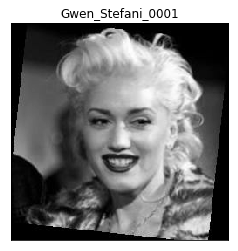

In [91]:
import matplotlib.pyplot as plt

img_path = list(train_paths_names_dict.values())[0]
# print(img_path)
# label = all_image_labels[0]

plt.imshow(np.squeeze(load_and_preprocess_image(img_path)), cmap='gray', vmin=0, vmax=255)
plt.grid(False)
plt.title(list(train_paths_names_dict.keys())[0])
plt.xticks([])
plt.yticks([])
print()

In [0]:
def create_image_ds(image_paths):
  path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
  # print(path_ds)
  image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
  return image_ds

def create_label_ds(labels, dtype=tf.bool):
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.bool))
  return label_ds

#### Testing functions

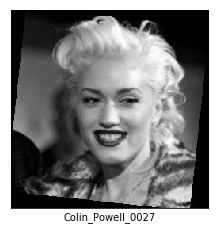

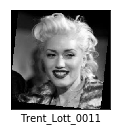

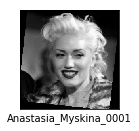

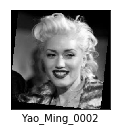

Same
Same
Same
Same
Same
Same
Same
Same
Same
Same


In [149]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=255)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(list(train_paths_names_dict.keys())[n])
  plt.show()
  
label_ds = create_label_ds([ l[2] for l in train_labels ])
for label in label_ds.take(10):
  print(label_names[int(label.numpy())])

#### Loading Datasets and labels

In [0]:
train_ds_left = create_image_ds([ train_paths_names_dict[l[0]] for l in train_labels ])
train_ds_right = create_image_ds([ train_paths_names_dict[l[1]] for l in train_labels ])
train_ds_labels = create_label_ds([ l[2] for l in train_labels ])

test_ds_left = create_image_ds([ test_paths_names_dict[l[0]] for l in test_labels ])
test_ds_right = create_image_ds([ test_paths_names_dict[l[1]] for l in test_labels ])
test_ds_labels = create_label_ds([ l[2] for l in test_labels ])

In [0]:
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

In [0]:
train_paths_names_dict

In [0]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

###Import Libararies

In [6]:
import numpy as np
from keras.models import Sequential
import time
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers import Conv3D
from keras.models import Model
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, MaxPooling3D
from keras.layers.core import Lambda, Flatten, Dense
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


###Build Network

In [0]:
def initialize_bias(shape, name=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)
  
def initialize_weights_dense(shape, name=None):
    return np.random.normal(loc = 0.0, scale = 0.2, size = shape)

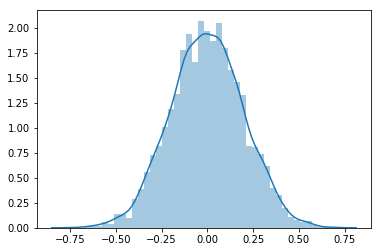

In [8]:
import seaborn as sns
weights = initialize_weights_dense((4096,1))
sns.distplot(weights)

In [0]:
def get_siamese_model(input_shape):
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(2048, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights_dense,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [10]:
model = get_siamese_model((250, 250, 1))

AttributeError: ignored

In [0]:
model.summary()

### UP TO HERE

In [0]:
train_pairs = []
train_names = set()
with open("trainPairs.txt") as train:
  train_files = train.readlines()[1:]
  
for pair in train_files:
  pair = pair[:-1].split('\t')
  if len(pair) == 3:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = name1
    id2 = pair[2].zfill(4)
    
    train_names.add(name1)
    
  elif len(pair) == 4:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = pair[2]
    id2 = pair[3].zfill(4)
    
    train_names.add(name1)
    train_names.add(name2)
  train_pairs.append((name1 + '_' + id1, name2 + '_' + id2))
train_names = list(train_names)

In [0]:
test_pairs = []
test_names = set()
with open("testPairs.txt") as test:
  test_files = test.readlines()[1:]
  
for pair in test_files:
  pair = pair[:-1].split('\t')
  if len(pair) == 3:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = name1
    id2 = pair[2].zfill(4)
    
    test_names.add(name1)
    
  elif len(pair) == 4:
    name1 = pair[0]
    id1 = pair[1].zfill(4)
    name2 = pair[2]
    id2 = pair[3].zfill(4)
    
    test_names.add(name1)

    test_names.add(name2)
  test_pairs.append((name1 + '_' + id1, name2 + '_' + id2))
test_names = list(test_names)

In [0]:
src = "lfw2/"
train_dir = "data/train/"
test_dir = "data/test/"

for name in train_names:
  print("Moving " + name + "...")
  shutil.copytree(src + name, train_dir + name)
  

Moving Charlotte_Rampling...


FileNotFoundError: ignored